**Loading Libraries**

In [1]:
library(diversedata)      # Diverse Data Hub data set
library(tidyverse)
library(VIM)
library(gridExtra)
library(mice)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filte

# 1 Data Cleaning & Processing

In [2]:
global_rights <- globalrights

# Select and clean variables (excluding marriage from transformation)
cleaned_rights <- global_rights |>
  select(
    country,
    year,
    `gdp-per-capita`,
    `education-spending-gdp`,
    `same-sex-marriage`,
    `lgbtq-censorship`,
    `employment-discrimination`,
    `gender-affirming-care`,
    `legal-gender`
  ) |>
  as.data.frame()

# Rename columns
colnames(cleaned_rights) <- c(
  "country", "year", "gdp_per_capita", "edu_spend", "same_sex_marriage",
  "lgbtq_censorship", "employment", "affirming_care", "legal_gender"
)

# 2 Aggregation Plots

The first fundamental question to ask is: which variables contain missing values, and how many observations are affected? Aggregation plots are a useful tool to quickly summarize and visualize the extent of missingness across all variables in the data set.

Please note that :

-   Each row in the plot represents a unique pattern of missingness across your variables. For example, one row might show only `gdp-per-capita` is missing and another might show `edu_spend` and `employment` are missing together.

-   The height of each bar on the left indicates the number (or percentage) of rows in our data that match that missing pattern.

Warning message in plot.aggr(res, ...):
“not enough vertical space to display frequencies (too many combinations)”


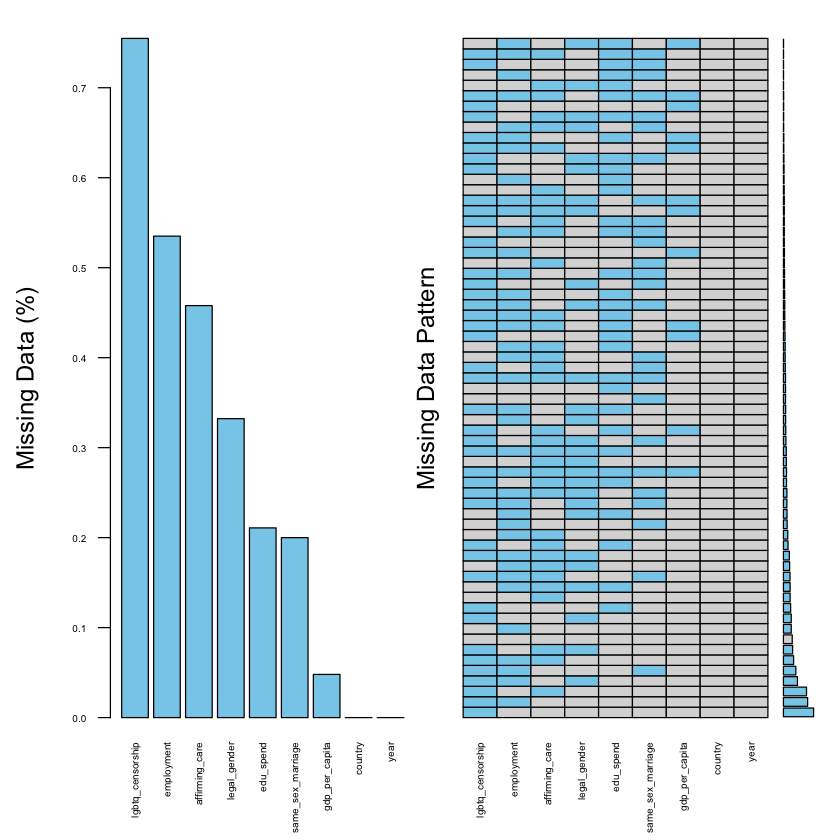

In [3]:
# Visualize missing values across all variables
invisible(
  capture.output(
    aggr(
      cleaned_rights,
      numbers = TRUE,
      prop = c(TRUE, FALSE),
      sortVars = TRUE,
      cex.axis = 0.5,
      las = 2,  # vertical labels
      gap = 2,
      col = c("gray85", "skyblue"),
      ylab = c("Missing Data (%)", "Missing Data Pattern")
    )
  )
)

The aggregation plot provides a clear overview of missingness across variables in the data set. From this visualization, it is evident that several categorical variables particularly `lgbtq-censorship`, `employment`, and `affirming-care` contain substantial amounts of missing data. Among the continuous variables, education spending (`edu-spend`) stands out as having more missing values than `gdp-per-capita`, which may reflect inconsistencies in government reporting or data availability across countries. Many variables in this data set have missing values, so handling missing data is an important step in preparing the data.

Given the extent of missing data observed in the aggregation plot, we will take a closer look at selected variables to better understand the underlying patterns of missingness. Specifically, we focus on the following variables:

-   `gdp-per-capita` and `edu-spend`, as key continuous indicators of national economic and educational investment. These variables are central to many of the analyses in this data set and missingness here may influence statistical outcomes if not properly addressed.

-   `same-sex-marriage` represents a key dimension of legal recognition for LGBTQ+ individuals. This categorical variable shows substantial missingness, which may reflect patterns tied to reporting practices or regional legal disparities in the recognition of same-sex unions. It includes seven categories that capture the varying legal statuses across countries: Banned, Civil union or other partnership, Unrecognized, Unregistered cohabitation, Legal, Varies by region, and Foreign same-sex marriages recognized only.

# 3 Spinogram and Spineplot

So far, we have gained a high-level overview of missingness across the data set. To dig deeper, we now examine how missing values in one variable relate to the categories of another. This helps us understand whether missingness may be random or related to other features in the data.

The function `spineMiss()` from the `{VIM}` package is used for this purpose. It produces a spineplot, a type of bar chart that visualizes the distribution of missing vs. non-missing values in a variable (in this case, `gdp`) across the levels of a categorical variable (in this case, `same-sex-marriage`).

By running `spineMiss(cleaned_rights[, c("marriage", "gdp")])`, we create a plot that shows, for each category of same-sex marriage recognition (e.g., Legal, Civil Union, Not Recognized), the proportion of observations where GDP is missing versus observed.

This visualization allows us to assess whether missing GDP values are evenly distributed across marriage groups (which might suggest MCAR: *Missing Completely at Random*), or if they are more prevalent in certain categories (which could suggest MAR: *Missing at Random*). It’s a helpful diagnostic tool to explore whether the missingness in `gdp-per-capita` is associated with legal recognition of same-sex marriage, which is crucial before deciding how to impute or model the data.

Please note that, based on *Flexible Imputation of Missing Data* by Stef van Buuren (2018), you can find the definitions as follows:

-   MCAR (Missing Completely at Random): The probability of missingness is unrelated to any observed or unobserved data. In other words, missing data occur entirely at random.

-   MAR (Missing at Random): The probability of missingness may depend on observed data but not on the missing values themselves. For example, GDP might be missing more often in countries without same-sex marriage laws, but not because of the GDP value itself.

-   MNAR (Missing Not at Random): The probability of missingness depends on the value of the missing data itself. For example, countries with very low GDP might be less likely to report it.

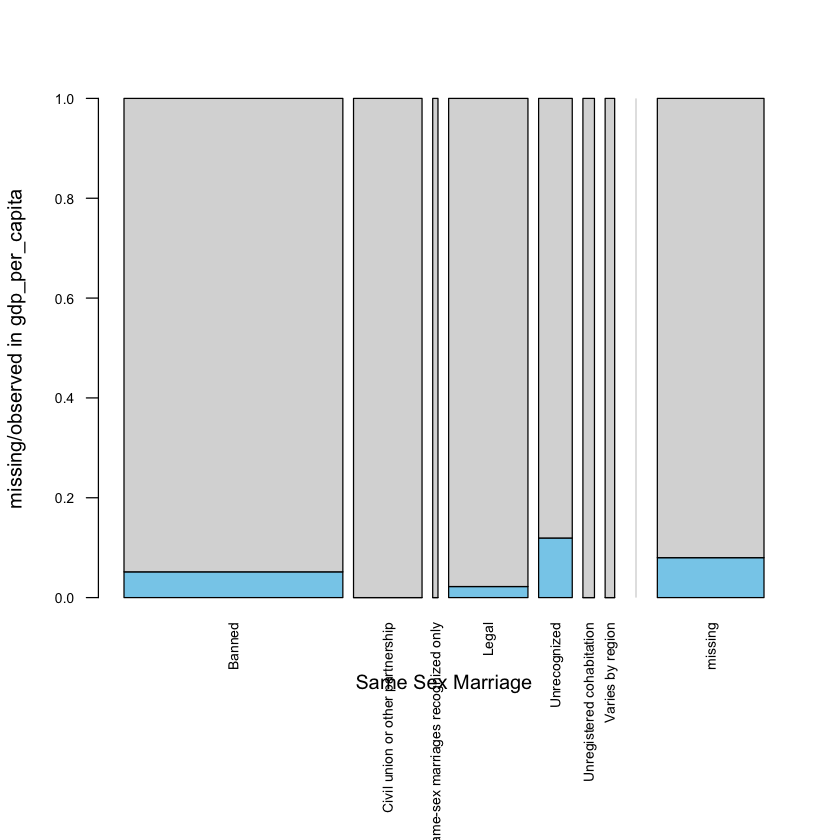

In [4]:
# Visualize missingness in GDP per capita across legal gender categories
par(mar = c(10, 4, 4, 2) + 0.1)
spineMiss(cleaned_rights[, c("same_sex_marriage", "gdp_per_capita")],
          col = c("gray85", "skyblue"),
          cex.axis = 0.7,         
          las = 2,                
          xlab = "Same Sex Marriage")

The spine plot shows that missing values in `gdp-per-capita` are not distributed evenly across the levels of `same-sex-marriage` recognition. Between seven categories, missingness is most frequent in countries where same-sex marriages are Unrecognized, followed by those where same-sex marriage is Banned, and then in countries where it is Legal.

This pattern suggests that the missingness in GDP is likely not completely at random, and may be associated with marriage recognition status, indicating a Missing At Random (MAR) mechanism. Recognizing this pattern is important, as it can guide the selection of appropriate imputation strategies that account for such relationships.

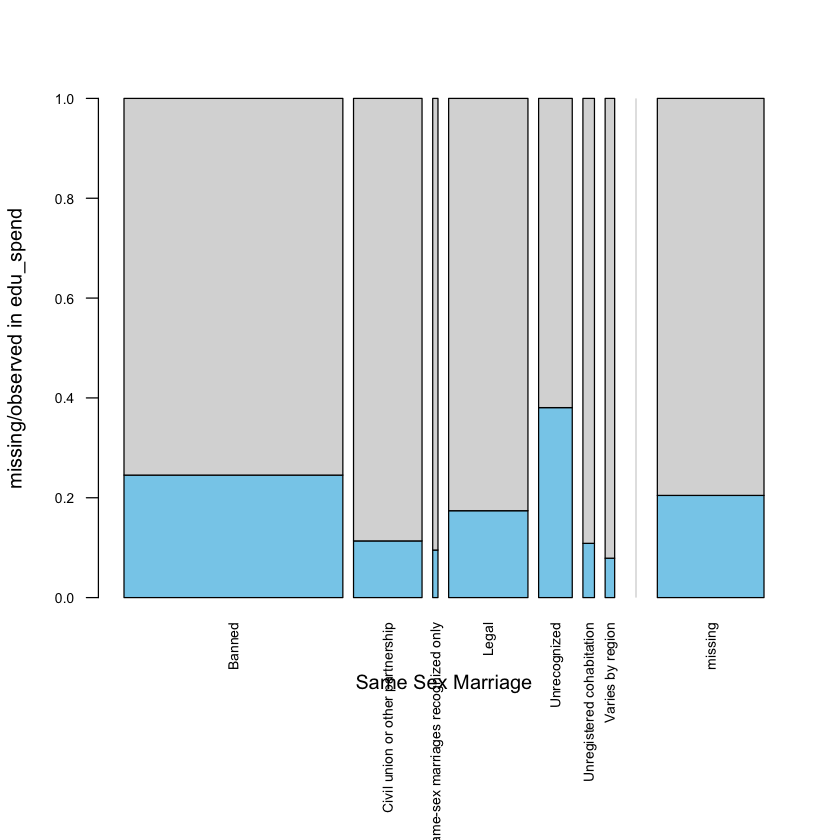

In [5]:
# Visualize missingness in education spending across legal gender categories
par(mar = c(10, 4, 4, 2) + 0.1)
spineMiss(cleaned_rights[, c("same_sex_marriage", "edu_spend")],
          col = c("gray85", "skyblue"),
          cex.axis = 0.7,         
          las = 2,                
          xlab = "Same Sex Marriage")

The spine plot for `edu-spend` across `same-sex-marriage` categories reveals that missing values are present in all levels of marriage recognition, unlike `gdp`, where missingness was more concentrated. Again between seven categories, missingness is most frequent in countries where same-sex marriages are Unrecognized, followed by those where same-sex marriage is Banned, and then in countries where it is Legal. We can also see that the Civil union or other partnership category has missing values

This widespread but uneven distribution suggests that the missingness in education spending is likely not completely at random (MCAR). Instead, it may be Missing At Random (MAR), as the probability of missing values appears to vary with observed levels of legal recognition. This pattern underscores the importance of considering contextual legal factors when handling missing values for `edu-spend`, as they may be informative and should influence imputation choices.

# 4 Multivariate Imputation by Chained Equations (MICE) using PMM

We used [MICE](https://www.jstatsoft.org/article/view/v045i03) with predictive mean matching (PMM) because it is well-suited to data sets with multiple partially missing variables, allows for realistic value imputation, and accommodates the MAR mechanism observed in o

Through earlier visualizations (like `spineMiss` and `mosaicMiss`), we observed that the missing values in `gdp` and `edu_spend` depend on other variables (e.g., marriage status). This suggests the data are Missing at Random (MAR) where imputation models should account for relationships between variables.

We used Predictive Mean Matching (PMM) to impute missing values in continuous variables like GDP and education spending. This method ensures that the imputed values are realistic and drawn from the actual data distribution, avoiding extreme or implausible results like negative GDP. Because these variables are often skewed, PMM offers a more robust alternative to linear regression.

To handle multiple variables with missing values, we applied the MICE algorithm, which builds a separate model for each incomplete variable using relevant predictors like marriage status, employment protection, and legal gender. This approach allows for flexible and iterative imputation, especially effective when missingness is spread across several variables.

Finally, MICE generates multiple imputed data sets, which supports transparent and reproducible analysis while accounting for uncertainty in the missing data.

In [6]:
impute_df <- cleaned_rights |>
  select(gdp_per_capita, edu_spend, same_sex_marriage, lgbtq_censorship, employment, affirming_care, legal_gender)

impute_df <- impute_df |>
  mutate(
    marriage = as.factor(same_sex_marriage),
    censorship = as.factor(lgbtq_censorship),
    employment = as.factor(employment),
    affirming_care = as.factor(affirming_care),
    legal_gender = as.factor(legal_gender)
  )

set.seed(123)
imputed <- mice(impute_df, method = "pmm", m = 5)


 iter imp variable
  1   1  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  1   2  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  1   3  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  1   4  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  1   5  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  2   1  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  2   2  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  2   3  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  2   4  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  censorship
  2   5  gdp_per_capita  edu_spend  employment  affirming_care  legal_gender  marriage  c

Warning message:
“Number of logged events: 12”


# 5 Visual Comparison for Before and After Imputation

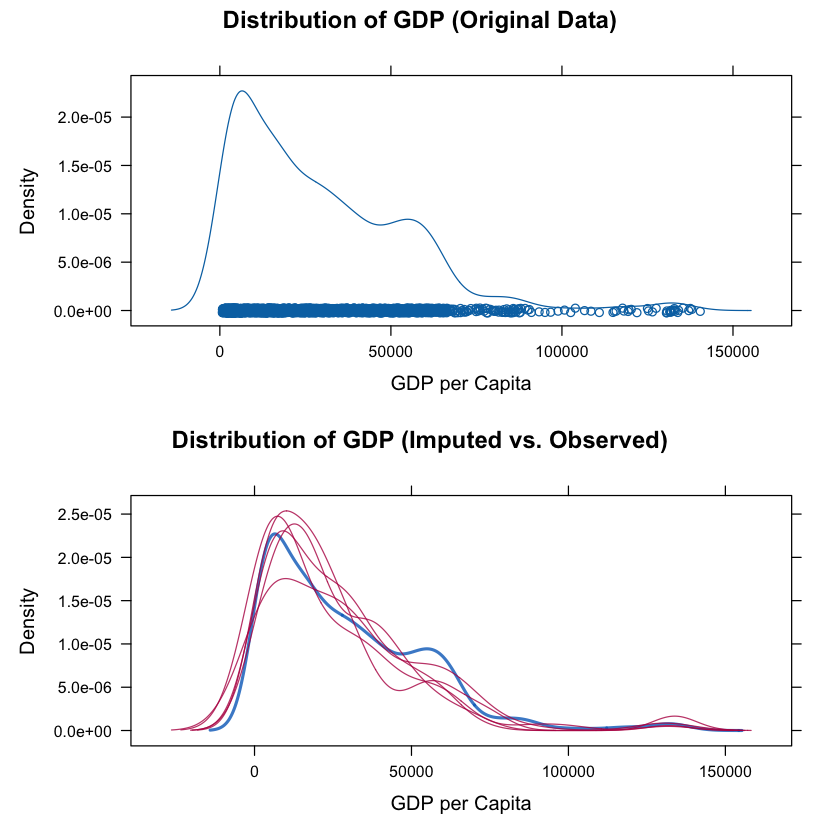

In [7]:
plot_before <- densityplot(~ gdp_per_capita, data = cleaned_rights,
                           main = "Distribution of GDP (Original Data)",
                           xlab = "GDP per Capita")

plot_after <- densityplot(imputed, ~ gdp_per_capita,
                          main = "Distribution of GDP (Imputed vs. Observed)",
                          xlab = "GDP per Capita")

# Arrange the two plots vertically
grid.arrange(plot_before, plot_after, ncol = 1, heights = c(1, 1))

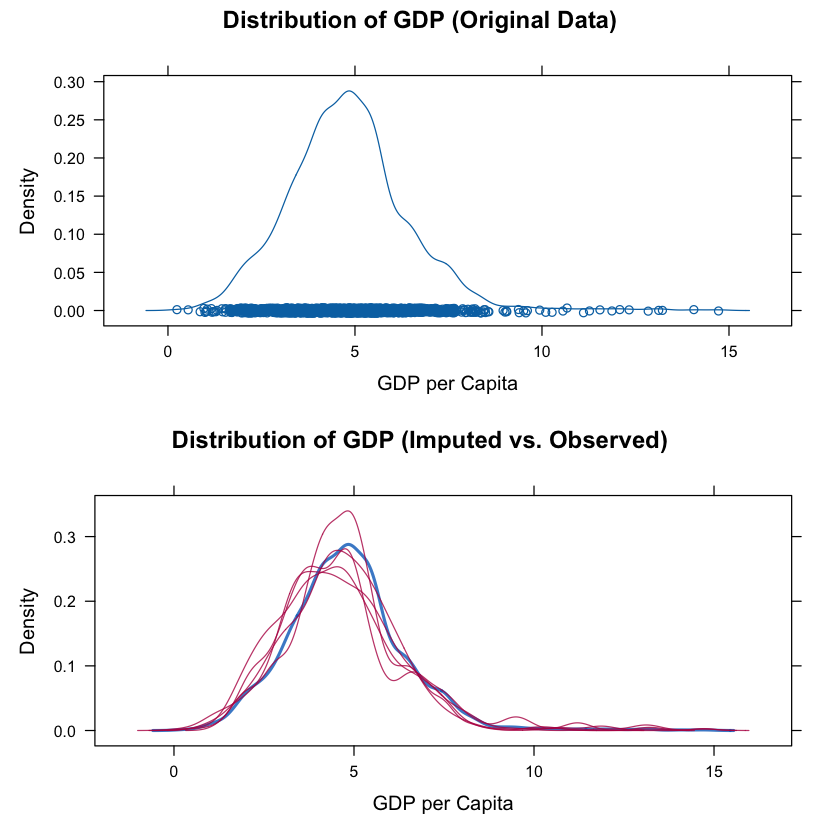

In [8]:
plot_before <- densityplot(~ edu_spend, data = cleaned_rights,
                           main = "Distribution of GDP (Original Data)",
                           xlab = "GDP per Capita")

plot_after <- densityplot(imputed, ~ edu_spend,
                          main = "Distribution of GDP (Imputed vs. Observed)",
                          xlab = "GDP per Capita")

# Arrange the two plots vertically
grid.arrange(plot_before, plot_after, ncol = 1, heights = c(1, 1))

# Discussion


Missing data can significantly hinder analysis, especially when it affects key economic indicators like GDP per capita and education spending. In this case study, we addressed missingness in both variables using Multiple Imputation by Chained Equations (MICE) with Predictive Mean Matching (PMM).

By including categorical predictors such as legal gender recognition, employment protection, marriage equality, and censorship laws, we aimed to generate imputations that reflect realistic values consistent with each country’s broader policy environment. The use of PMM ensured that imputed values were drawn from observed data points, preserving the original distribution and avoiding implausible values (e.g., negative GDP or unrealistic education spending).

We imputed both variables simultaneously within the same model, allowing the algorithm to borrow strength across variables and iterations. This approach reflects a more robust and context-aware method than imputing variables separately or using simple strategies like mean substitution.

Comparing the density plots of the original and imputed data revealed that the imputed values align well with the observed data distribution, suggesting that the imputations are not introducing substantial bias. This strengthens the reliability of subsequent statistical analyses such as ANOVA, regression modeling, or equity comparisons that rely on complete data sets.

However, there are some limitations to consider. While MICE with PMM preserves distributional properties, it still assumes that the data are missing at random (MAR), which may not hold true in all contexts particularly when data availability is tied to political or economic instability. Moreover, the inclusion of policy indicators as predictors helps contextualize imputations but may also introduce circular reasoning if those same indicators are later used as outcomes in analysis. Future work could explore sensitivity analyses to assess how different imputation models affect results or incorporate external data sources to validate imputed values. Addressing these limitations would further strengthen the robustness and credibility of equity-focused policy research.